In [17]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

# CONFIGURACIÓN DE CLASES
CLASS_A = 2
CLASS_B = 9

CLASS_NAMES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Load CIFAR-10
transform = transforms.ToTensor()
dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

# Class Filters
data = []
labels = []

for img, label in dataset:
    if label == CLASS_A:
        data.append(img)
        labels.append(0)
    elif label == CLASS_B:
        data.append(img)
        labels.append(1)

print(f"Total imágenes tomadas: {len(data)} | {CLASS_NAMES[CLASS_A]} vs {CLASS_NAMES[CLASS_B]}")




Total imágenes tomadas: 10000 | bird vs truck


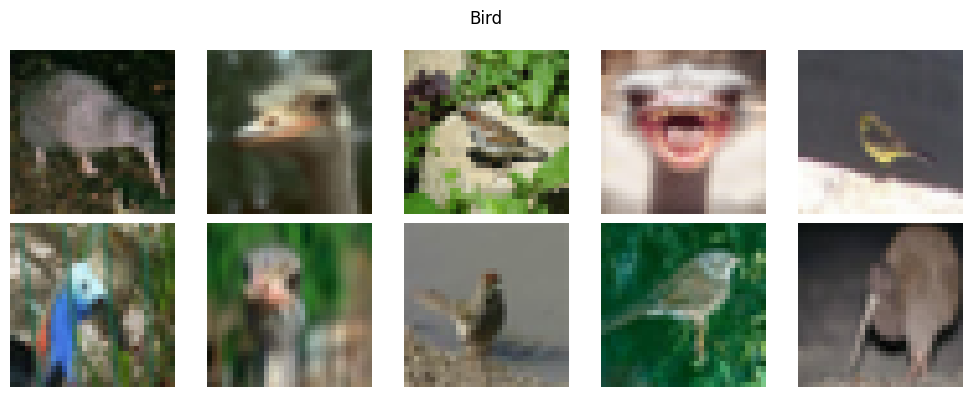

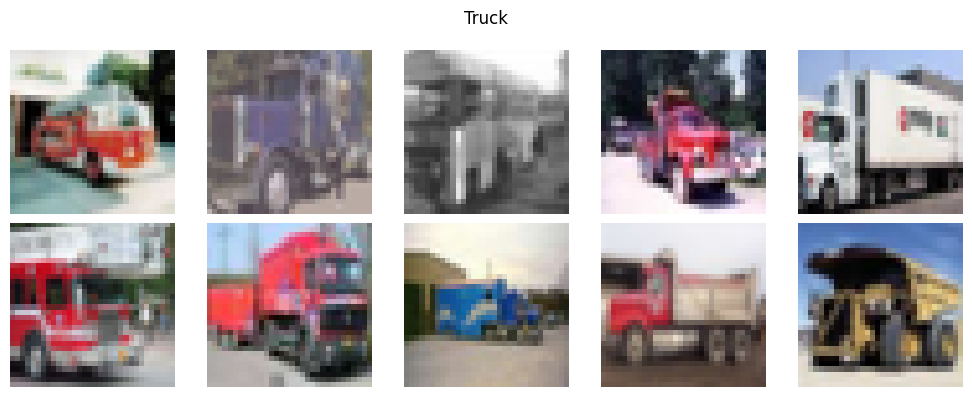

In [18]:
# Plotimages per class
def plot_images(data, labels, label_value, title):
    plt.figure(figsize=(10, 4))
    indices = [i for i, l in enumerate(labels) if l == label_value]
    n = min(10, len(indices))
    indices = np.random.choice(indices, size=n, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        img = data[idx].permute(1, 2, 0)
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_images(data, labels, 0, CLASS_NAMES[CLASS_A].capitalize())
plot_images(data, labels, 1, CLASS_NAMES[CLASS_B].capitalize())

In [19]:
# Conversion to grayscale
def rgb_to_grayscale(img):
    img = img.permute(1, 2, 0).numpy()
    return np.mean(img, axis=2)

# Filter 1: Scharr (detector de bordes mejorado)
scharr_filter = np.array([[-3, 0, 3],
                          [-10, 0, 10],
                          [-3, 0, 3]])

# Filter 2: Laplaciano (contornos generales)
laplacian_filter = np.array([[0,  1, 0],
                             [1, -4, 1],
                             [0,  1, 0]])
# MANUAL Convolution
def convolution(image, kernel):
    height, width = image.shape
    k_height, k_width = kernel.shape
    output = np.zeros((height - k_height + 1, width - k_width + 1))

    for i in range(height - k_height + 1):
        for j in range(width - k_width + 1):
            region = image[i:i + k_height, j:j + k_width]
            output[i, j] = np.sum(region * kernel)
    return output

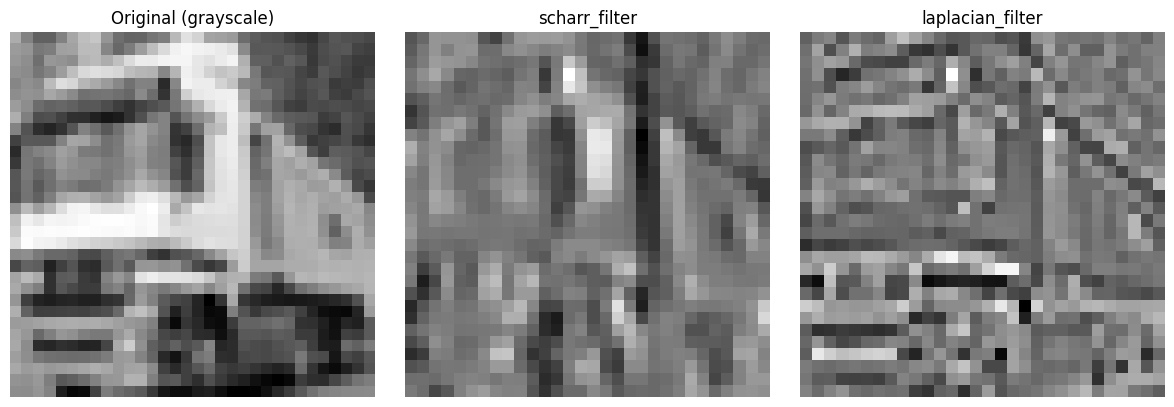

In [22]:
# Visualize Feature Maps
sample_img = rgb_to_grayscale(data[0])

scharr_result = convolution(sample_img, scharr_filter)
laplacian_result = convolution(sample_img, laplacian_filter)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original (grayscale)")
plt.imshow(sample_img, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("scharr_filter")
plt.imshow(scharr_result, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("laplacian_filter")
plt.imshow(laplacian_result, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

In [23]:
# Feature extraction
def edge_energy(img):
    gray = rgb_to_grayscale(img)
    edges = convolution(gray, scharr_filter)
    return np.mean(np.abs(edges))

# Define threshold (without training)
bird_energy = []
truck_energy = []

n_calib = min(200, len(data))
for img, label in zip(data[:n_calib], labels[:n_calib]):
    if label == 0:
        bird_energy.append(edge_energy(img))
    else:
        truck_energy.append(edge_energy(img))

threshold = (np.mean(bird_energy) + np.mean(truck_energy)) / 2
print("Threshold:", threshold)

Threshold: 1.3177864520396203


Accuracy: 69.40%


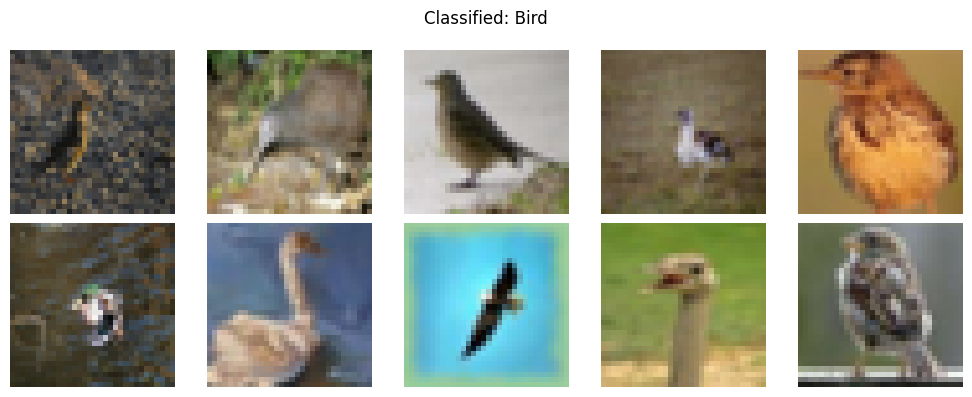

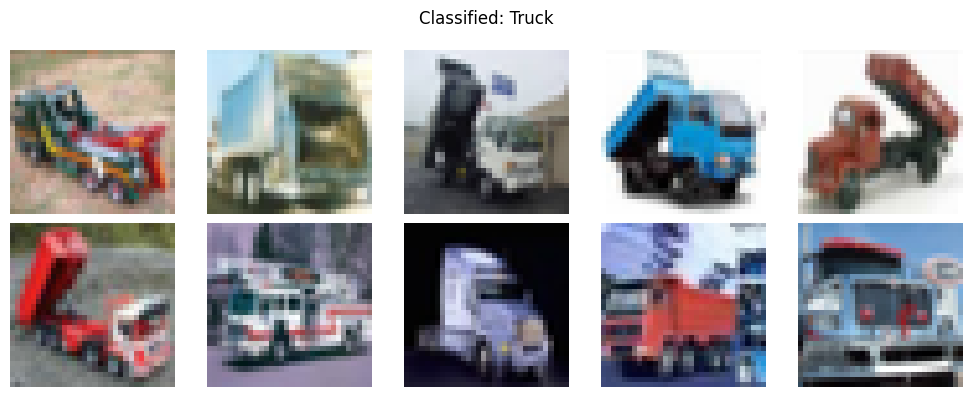

In [33]:
# Classification based on rules
def classify(img, threshold):
    energy = edge_energy(img)
    return 0 if energy < threshold else 1

# Evaluate Accuracy
start = n_calib
end = min(start + 500, len(data))
correct = 0
total = max(0, end - start)

classified_images_class_0 = []
classified_images_class_1 = []

for img, label in zip(data[start:end], labels[start:end]):
    pred = classify(img, threshold)
    if pred == label:
        correct += 1
        if label == 0:
            classified_images_class_0.append(img)
        else:
            classified_images_class_1.append(img)

accuracy = (correct / total * 100) if total > 0 else 0.0
print(f"Accuracy: {accuracy:.2f}%")

# Plot images
plot_images(classified_images_class_0, [0]*len(classified_images_class_0), 0, f"Classified: {CLASS_NAMES[CLASS_A].capitalize()}")
plot_images(classified_images_class_1, [1]*len(classified_images_class_1), 1, f"Classified: {CLASS_NAMES[CLASS_B].capitalize()}")